#### Sepehr Rezaee 99242067

# Fasion MNIST Classifier

## Requierments:

In [4]:
#importing required libraries..
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test

## Enable Cuda

In [5]:
if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"

device = torch.device(dev)
print(device)

cuda


## Download dataset and divide it into train and test set

In [6]:
#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), therefore we should add a comma after the values
                          
#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#Preparin for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [7]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


## Define basic model

In [8]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)
    #defining the 20% dropout
    #self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    #not using dropout on output layer
    x = F.log_softmax(self.fc4(x), dim=1)
    return x

## Train and Test

In [9]:
model = Classifier()
#defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5, lr=0.003)


valid_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 30
steps = 0

train_losses, test_losses, valid_losses = [],[],[]
for e in range(epochs):
  running_loss =0 
  valid_loss = 0
  for images, labels in trainloader:

     optimizer.zero_grad()
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     loss.backward()
     optimizer.step()
     running_loss += loss.item()

  for images, labels in validloader:
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     valid_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(trainloader.sampler)
  valid_loss =  valid_loss/len(validloader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))

  if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.012826 	Validation Loss: 0.640286
validation loss decreased(inf -->0.640286). Saving Model ...
Epoch: 2 	Training Loss: 0.009063 	Validation Loss: 0.597244
validation loss decreased(0.640286 -->0.597244). Saving Model ...
Epoch: 3 	Training Loss: 0.008410 	Validation Loss: 0.562378
validation loss decreased(0.597244 -->0.562378). Saving Model ...
Epoch: 4 	Training Loss: 0.007671 	Validation Loss: 0.556502
validation loss decreased(0.562378 -->0.556502). Saving Model ...
Epoch: 5 	Training Loss: 0.007500 	Validation Loss: 0.500107
validation loss decreased(0.556502 -->0.500107). Saving Model ...
Epoch: 6 	Training Loss: 0.007025 	Validation Loss: 0.515134
Epoch: 7 	Training Loss: 0.006828 	Validation Loss: 0.487111
validation loss decreased(0.500107 -->0.487111). Saving Model ...
Epoch: 8 	Training Loss: 0.006698 	Validation Loss: 0.483361
validation loss decreased(0.487111 -->0.483361). Saving Model ...
Epoch: 9 	Training Loss: 0.006310 	Validation Loss: 0.5

## Part 1

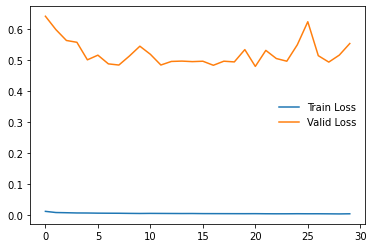

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend(frameon = False)

As you can see, our training loss has no moving but validation loss decreased.

## Part 2

#### The depths effect

In [11]:
depth_1 = nn.Sequential(nn.Linear(784, 512),
                           nn.ReLU(),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 10),
                           nn.LogSoftmax(dim=1)
                           )
optimizer_1 = optim.Adam(depth_1.parameters(), weight_decay=1e-5, lr= 0.002)

In [12]:
depth_2 = nn.Sequential(nn.Linear(784, 512),
                           nn.ReLU(),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 32),
                           nn.ReLU(),
                           nn.Linear(32, 10),
                           nn.LogSoftmax(dim=1)
                           )
optimizer_2 = optim.Adam(depth_2.parameters(), weight_decay=1e-5, lr= 0.002)

In [13]:
depth_3 = nn.Sequential(nn.Linear(784, 512),
                           nn.ReLU(),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 32),
                           nn.ReLU(),
                           nn.Linear(32, 16),
                           nn.ReLU(),
                           nn.Linear(16, 10),
                           nn.LogSoftmax(dim=1)
                           )
optimizer_3 = optim.Adam(depth_3.parameters(), weight_decay=1e-5, lr= 0.002)

In [14]:
depth_4 = nn.Sequential(nn.Linear(784, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 32),
                           nn.ReLU(),
                           nn.Linear(32, 16),
                           nn.ReLU(),
                           nn.Linear(16, 10),
                           nn.LogSoftmax(dim=1)
                           )
optimizer_4 = optim.Adam(depth_4.parameters(), weight_decay=1e-5, lr= 0.002)

In [16]:
def run_model(model, optimizer, epochs):
  train_losses, test_losses = [], []

  for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      test_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in testloader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
            "Test loss: {:.3f}..".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  return [train_losses, test_losses]

In [18]:
trains_losses = []
test_losses = []
models = [depth_1, depth_2, depth_3, depth_4]
optimizers = [optimizer_1, optimizer_2, optimizer_3, optimizer_4]
for i in range(4):
  print("Running model", i)
  results = run_model(models[i], optimizers[i], 15)
  trains_losses.append(results[0])
  test_losses.append(results[1])

Running model 0
Epoch: 1/15.. Training loss: 0.215.. Test loss: 0.541.. Test Accuracy: 0.831
Epoch: 2/15.. Training loss: 0.217.. Test loss: 0.471.. Test Accuracy: 0.862
Epoch: 3/15.. Training loss: 0.194.. Test loss: 0.525.. Test Accuracy: 0.847
Epoch: 4/15.. Training loss: 0.194.. Test loss: 0.561.. Test Accuracy: 0.845
Epoch: 5/15.. Training loss: 0.190.. Test loss: 0.531.. Test Accuracy: 0.850
Epoch: 6/15.. Training loss: 0.177.. Test loss: 0.560.. Test Accuracy: 0.854
Epoch: 7/15.. Training loss: 0.165.. Test loss: 0.546.. Test Accuracy: 0.848
Epoch: 8/15.. Training loss: 0.168.. Test loss: 0.570.. Test Accuracy: 0.854
Epoch: 9/15.. Training loss: 0.149.. Test loss: 0.628.. Test Accuracy: 0.847
Epoch: 10/15.. Training loss: 0.148.. Test loss: 0.651.. Test Accuracy: 0.840
Epoch: 11/15.. Training loss: 0.136.. Test loss: 0.633.. Test Accuracy: 0.852
Epoch: 12/15.. Training loss: 0.130.. Test loss: 0.640.. Test Accuracy: 0.852
Epoch: 13/15.. Training loss: 0.134.. Test loss: 0.640.. 

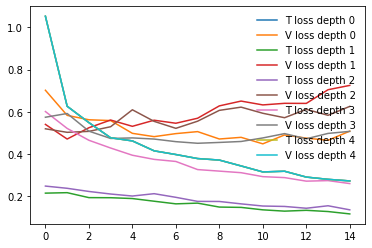

In [20]:
plt.plot(results[0], label = "T loss depth 0")
plt.plot(results[1], label = "V loss depth 0")
plt.plot(trains_losses[0], label = "T loss depth 1")
plt.plot(test_losses[0], label = "V loss depth 1")
plt.plot(trains_losses[1], label = "T loss depth 2")
plt.plot(test_losses[1], label = "V loss depth 2")
plt.plot(trains_losses[2], label = "T loss depth 3")
plt.plot(test_losses[2], label = "V loss depth 3")
plt.plot(trains_losses[3], label = "T loss depth 4")
plt.plot(trains_losses[3], label = "V loss depth 4")
plt.legend(frameon = False)

According to the abot chart, we have just one optimized network for FASHION Mnist task.

## Part 3

In [21]:
model_with_drop = nn.Sequential(nn.Linear(784, 256),
                           nn.ReLU(),
                           nn.Dropout(0.25),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Dropout(0.3),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(64, 10),
                           nn.LogSoftmax(dim=1)
                           )
optimizer_model_drop = optim.Adam(model_with_drop.parameters(), weight_decay=1e-5, lr= 0.002)

In [22]:
results_of_model_drop = run_model(model_with_drop, optimizer_model_drop, 20)

Epoch: 1/20.. Training loss: 1.004.. Test loss: 0.596.. Test Accuracy: 0.773
Epoch: 2/20.. Training loss: 0.661.. Test loss: 0.542.. Test Accuracy: 0.803
Epoch: 3/20.. Training loss: 0.591.. Test loss: 0.511.. Test Accuracy: 0.813
Epoch: 4/20.. Training loss: 0.556.. Test loss: 0.505.. Test Accuracy: 0.818
Epoch: 5/20.. Training loss: 0.531.. Test loss: 0.501.. Test Accuracy: 0.821
Epoch: 6/20.. Training loss: 0.505.. Test loss: 0.515.. Test Accuracy: 0.819
Epoch: 7/20.. Training loss: 0.490.. Test loss: 0.485.. Test Accuracy: 0.829
Epoch: 8/20.. Training loss: 0.468.. Test loss: 0.471.. Test Accuracy: 0.829
Epoch: 9/20.. Training loss: 0.451.. Test loss: 0.492.. Test Accuracy: 0.826
Epoch: 10/20.. Training loss: 0.445.. Test loss: 0.462.. Test Accuracy: 0.840
Epoch: 11/20.. Training loss: 0.434.. Test loss: 0.455.. Test Accuracy: 0.846
Epoch: 12/20.. Training loss: 0.430.. Test loss: 0.455.. Test Accuracy: 0.840
Epoch: 13/20.. Training loss: 0.408.. Test loss: 0.465.. Test Accuracy: 0

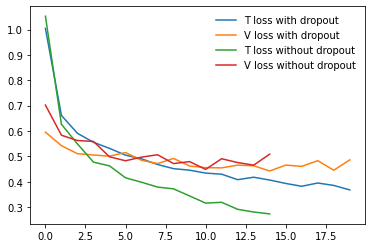

In [24]:
plt.plot(results_of_model_drop[0], label = "T loss with dropout")
plt.plot(results_of_model_drop[1], label = "V loss with dropout")
plt.plot(results[0], label = "T loss without dropout")
plt.plot(results[1], label = "V loss without dropout")
plt.legend(frameon = False)

Our modeling has better result when we use drop-out technique.

## Part 4

#### Early stopping

In [25]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

In [26]:
def run_model_early_stop(model, optimizer, epochs):
  train_losses, test_losses = [], []

  early_stopper = EarlyStopper(3, 10)
  for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      test_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in testloader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
      if early_stopper.early_stop(test_loss):
        print("Early stop has been triggered!")
        break

      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
            "Test loss: {:.3f}..".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  return [train_losses, test_losses]

In [28]:
results_early = run_model_early_stop(depth_1, optimizer_1, 20)

Epoch: 1/20.. Training loss: 0.116.. Test loss: 0.771.. Test Accuracy: 0.846
Epoch: 2/20.. Training loss: 0.117.. Test loss: 0.668.. Test Accuracy: 0.846
Epoch: 3/20.. Training loss: 0.095.. Test loss: 0.692.. Test Accuracy: 0.847
Epoch: 4/20.. Training loss: 0.112.. Test loss: 0.832.. Test Accuracy: 0.831
Epoch: 5/20.. Training loss: 0.130.. Test loss: 0.675.. Test Accuracy: 0.853
Epoch: 6/20.. Training loss: 0.102.. Test loss: 0.658.. Test Accuracy: 0.855
Epoch: 7/20.. Training loss: 0.085.. Test loss: 0.738.. Test Accuracy: 0.853
Epoch: 8/20.. Training loss: 0.096.. Test loss: 0.737.. Test Accuracy: 0.849
Early stop has been triggered!


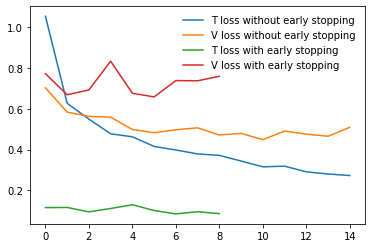

In [30]:
plt.plot(results[0], label = "T loss without early stopping")
plt.plot(results[1], label = "V loss without early stopping")
plt.plot(results_early[0], label = "T loss with early stopping")
plt.plot(results_early[1], label = "V loss with early stopping")
plt.legend(frameon = False)

Early stopping helped us to prevent model from overlearning and overfitting on data and reduce number of epochs that we need to feed forward and do back-propagation 

## Part 5

In [31]:
model_part5 = nn.Sequential(nn.Linear(784, 256),
                           nn.ReLU(),
                           nn.Dropout(0.25),
                           nn.BatchNorm1d(256),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Dropout(0.3),
                           nn.BatchNorm1d(128),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.BatchNorm1d(64),
                           nn.Linear(64, 10),
                           nn.LogSoftmax(dim=1)
                           )
optimizer_part5 = optim.Adam(model_part5.parameters(), weight_decay=1e-5, lr= 0.002)

In [32]:
batch_results = run_model(model_part5, optimizer_part5, 20)

Epoch: 1/20.. Training loss: 1.027.. Test loss: 0.628.. Test Accuracy: 0.785
Epoch: 2/20.. Training loss: 0.704.. Test loss: 0.668.. Test Accuracy: 0.787
Epoch: 3/20.. Training loss: 0.659.. Test loss: 0.734.. Test Accuracy: 0.812
Epoch: 4/20.. Training loss: 0.629.. Test loss: 0.680.. Test Accuracy: 0.810
Epoch: 5/20.. Training loss: 0.589.. Test loss: 0.675.. Test Accuracy: 0.813
Epoch: 6/20.. Training loss: 0.572.. Test loss: 0.697.. Test Accuracy: 0.811
Epoch: 7/20.. Training loss: 0.575.. Test loss: 0.679.. Test Accuracy: 0.822
Epoch: 8/20.. Training loss: 0.555.. Test loss: 0.675.. Test Accuracy: 0.818
Epoch: 9/20.. Training loss: 0.548.. Test loss: 0.687.. Test Accuracy: 0.814
Epoch: 10/20.. Training loss: 0.549.. Test loss: 0.639.. Test Accuracy: 0.827
Epoch: 11/20.. Training loss: 0.542.. Test loss: 0.591.. Test Accuracy: 0.830
Epoch: 12/20.. Training loss: 0.520.. Test loss: 0.543.. Test Accuracy: 0.834
Epoch: 13/20.. Training loss: 0.510.. Test loss: 0.600.. Test Accuracy: 0

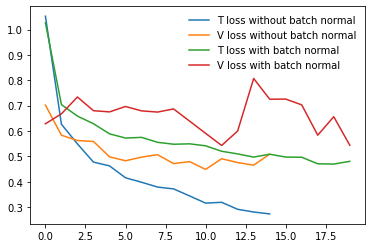

In [33]:
plt.plot(results[0], label = "T loss without batch normal")
plt.plot(results[1], label = "V loss without batch normal")
plt.plot(batch_results[0], label = "T loss with batch normal")
plt.plot(batch_results[1], label = "V loss with batch normal")
plt.legend(frameon = False)

Based on the above plot, batch normalization could help out to increasing accuracy smothly.

## Part 6

In [34]:
def run_model_L2(model, optimizer, epochs, alpha):
  train_losses, test_losses = [], []
  for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      l2_reg = None
      for i in model.named_parameters():
        if l2_reg is None:
          l2_reg = torch.sum(i[1].norm(2) ** 2)
        else:
          l2_reg += torch.sum(i[1].norm(2) ** 2)
      output = model.forward(images)
      loss = criterion(output, labels)
      loss += alpha * l2_reg
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      test_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in testloader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
            "Test loss: {:.3f}..".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  return [train_losses, test_losses]

In [35]:
def run_model_L1(model, optimizer, epochs, alpha):
  train_losses, test_losses = [], []
  for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
      images = images.view(images.shape[0], -1)
      
      optimizer.zero_grad()
      
      l1_reg = None
      for i in model.named_parameters():
        if l1_reg is None:
          l1_reg = torch.sum(i[1].__abs__())
        else:
          l1_reg += torch.sum(i[1].__abs__())

      output = model.forward(images)
      loss = criterion(output, labels)
      loss = loss + alpha * l1_reg
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    else:
      test_loss = 0
      accuracy = 0
      
      with torch.no_grad():
        model.eval()
        
        for images, labels in testloader:
          images = images.view(images.shape[0], -1)
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
      
      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
            "Test loss: {:.3f}..".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  return [train_losses, test_losses]

In [36]:
l2_results = run_model_L2(depth_1, optimizer_1, 20, 1e-4)

Epoch: 1/20.. Training loss: 0.583.. Test loss: 0.733.. Test Accuracy: 0.852
Epoch: 2/20.. Training loss: 0.504.. Test loss: 0.701.. Test Accuracy: 0.845
Epoch: 3/20.. Training loss: 0.462.. Test loss: 0.696.. Test Accuracy: 0.851
Epoch: 4/20.. Training loss: 0.415.. Test loss: 0.715.. Test Accuracy: 0.849
Epoch: 5/20.. Training loss: 0.398.. Test loss: 0.679.. Test Accuracy: 0.854
Epoch: 6/20.. Training loss: 0.373.. Test loss: 0.717.. Test Accuracy: 0.858
Epoch: 7/20.. Training loss: 0.370.. Test loss: 0.617.. Test Accuracy: 0.855
Epoch: 8/20.. Training loss: 0.350.. Test loss: 0.677.. Test Accuracy: 0.853
Epoch: 9/20.. Training loss: 0.351.. Test loss: 0.602.. Test Accuracy: 0.856
Epoch: 10/20.. Training loss: 0.323.. Test loss: 0.659.. Test Accuracy: 0.850
Epoch: 11/20.. Training loss: 0.322.. Test loss: 0.621.. Test Accuracy: 0.853
Epoch: 12/20.. Training loss: 0.323.. Test loss: 0.661.. Test Accuracy: 0.845
Epoch: 13/20.. Training loss: 0.295.. Test loss: 0.694.. Test Accuracy: 0

In [37]:
model2 = nn.Sequential(nn.Linear(784, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 10),
                           nn.LogSoftmax(dim=1)
                           )
criterion = nn.NLLLoss()
optimizer2 = optim.Adam(model2.parameters(), weight_decay=1e-5, lr= 0.002)

In [38]:
l1_results = run_model_L1(model2, optimizer2, 30, 0.0001)

Epoch: 1/30.. Training loss: 1.102.. Test loss: 0.589.. Test Accuracy: 0.775
Epoch: 2/30.. Training loss: 0.808.. Test loss: 0.545.. Test Accuracy: 0.798
Epoch: 3/30.. Training loss: 0.761.. Test loss: 0.507.. Test Accuracy: 0.820
Epoch: 4/30.. Training loss: 0.701.. Test loss: 0.486.. Test Accuracy: 0.822
Epoch: 5/30.. Training loss: 0.641.. Test loss: 0.480.. Test Accuracy: 0.818
Epoch: 6/30.. Training loss: 0.624.. Test loss: 0.523.. Test Accuracy: 0.804
Epoch: 7/30.. Training loss: 0.591.. Test loss: 0.514.. Test Accuracy: 0.816
Epoch: 8/30.. Training loss: 0.578.. Test loss: 0.466.. Test Accuracy: 0.832
Epoch: 9/30.. Training loss: 0.550.. Test loss: 0.495.. Test Accuracy: 0.822
Epoch: 10/30.. Training loss: 0.540.. Test loss: 0.486.. Test Accuracy: 0.828
Epoch: 11/30.. Training loss: 0.516.. Test loss: 0.461.. Test Accuracy: 0.841
Epoch: 12/30.. Training loss: 0.529.. Test loss: 0.462.. Test Accuracy: 0.835
Epoch: 13/30.. Training loss: 0.510.. Test loss: 0.471.. Test Accuracy: 0

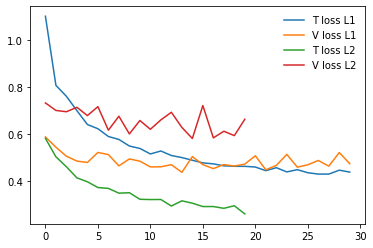

In [39]:
plt.plot(l1_results[0], label = "T loss L1")
plt.plot(l1_results[1], label = "V loss L1")
plt.plot(l2_results[0], label = "T loss L2")
plt.plot(l2_results[1], label = "V loss L2")
plt.legend(frameon = False)

In [40]:
model_l2 = nn.Sequential(nn.Linear(784, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 10),
                           nn.LogSoftmax(dim=1)
                           )
criterion = nn.NLLLoss()
optimizer_l2 = optim.Adam(model_l2.parameters(), weight_decay=1e-5, lr= 0.002)

In [41]:
alphas = [1e-3, 1e-4, 1e-5]
alpha_results = []
for alpha in alphas:
    print("Running on alpha=", alpha)
    alpha_results .append(run_model_L2(model_l2, optimizer_l2, 20, alpha))

Running on alpha= 0.001
Epoch: 1/20.. Training loss: 0.884.. Test loss: 0.616.. Test Accuracy: 0.777
Epoch: 2/20.. Training loss: 0.673.. Test loss: 0.552.. Test Accuracy: 0.797
Epoch: 3/20.. Training loss: 0.628.. Test loss: 0.495.. Test Accuracy: 0.818
Epoch: 4/20.. Training loss: 0.596.. Test loss: 0.530.. Test Accuracy: 0.810
Epoch: 5/20.. Training loss: 0.586.. Test loss: 0.533.. Test Accuracy: 0.807
Epoch: 6/20.. Training loss: 0.585.. Test loss: 0.513.. Test Accuracy: 0.809
Epoch: 7/20.. Training loss: 0.555.. Test loss: 0.484.. Test Accuracy: 0.823
Epoch: 8/20.. Training loss: 0.541.. Test loss: 0.468.. Test Accuracy: 0.827
Epoch: 9/20.. Training loss: 0.524.. Test loss: 0.495.. Test Accuracy: 0.823
Epoch: 10/20.. Training loss: 0.524.. Test loss: 0.472.. Test Accuracy: 0.832
Epoch: 11/20.. Training loss: 0.510.. Test loss: 0.564.. Test Accuracy: 0.795
Epoch: 12/20.. Training loss: 0.510.. Test loss: 0.532.. Test Accuracy: 0.812
Epoch: 13/20.. Training loss: 0.492.. Test loss: 

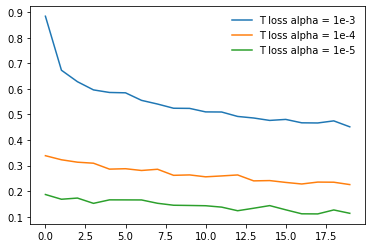

In [42]:
plt.plot(alpha_results[0][0], label = "T loss alpha = 1e-3")
plt.plot(alpha_results[1][0], label = "T loss alpha = 1e-4")
plt.plot(alpha_results[2][0], label = "T loss alpha = 1e-5")
plt.legend(frameon = False)


Plotting test loss for these alphas

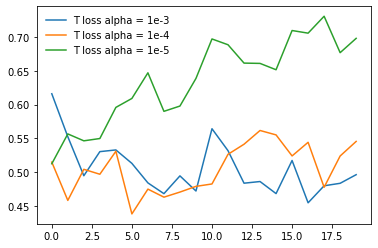

In [43]:
plt.plot(alpha_results[0][1], label = "T loss alpha = 1e-3")
plt.plot(alpha_results[1][1], label = "T loss alpha = 1e-4")
plt.plot(alpha_results[2][1], label = "T loss alpha = 1e-5")
plt.legend(frameon = False)
